Dans cette version, on utilise des images en noir et blanc pour entrainer, tester et valider le modèle. On se rend compte qu'en plus de diminuer le temps de calcul, cela ne rend pas l'algorithme inapte à faire de bonnes prédictions.

Au contraire, on obtient 95% de précision, ce qui est mieux que sur la version précédente $(*)$, ou on utilisait plus de données.

$(*)$ Kan ett ConvNet känna igen Monet målningar ?

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import time
from keras import layers
from keras import models
from keras import optimizers

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

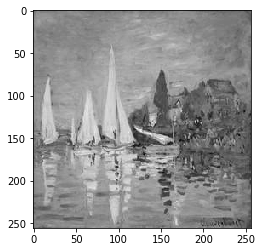

Pic size : (256, 256)
Length of the set : 300


In [2]:
# Loading the Monet paintings

Dir = '/Users/Casey/Desktop/Monet/monet_jpg'

def load_monet(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)        
        try:
            if img is not None:
                images.append(img/255)
        except Exception as e:
            pass
    return images

Monet = load_monet(Dir)
length_monet = len(Monet)

plt.imshow(Monet[0],cmap='gray')
plt.show()

print("Pic size :",Monet[0].shape)
print("Length of the set :",length_monet)

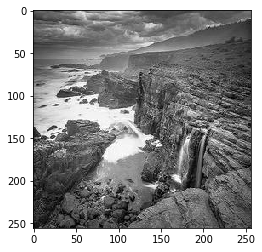

Pic size : (256, 256)
Length of the set : 5800


In [4]:
# Loading the Photos (Non-Monet)
offset=300

Dir_pics = '/Users/Casey/Desktop/Monet/photo_jpg'

def load_photos(folder,number):
    i=0
    images = []
    for filename in os.listdir(folder):
        i+=1
        if i==number+1:
            break
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE) 
        try:
            if img is not None:
                images.append(img/255)
        except Exception as e:
            pass
        
    return images

Photos = load_photos(Dir_pics,4800+offset)

plt.imshow(Photos[0],cmap='gray')
plt.show()

print("Pic size :",Photos[0].shape)
print("Length of the set :",len(Photos))

## Data Augmentation

In [5]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=.2,
                            height_shift_range=.2,shear_range=.2,
                            zoom_range=.2,horizontal_flip=True,
                            fill_mode='reflect')

# Listing of every Monet picture path
fnames = [os.path.join(Dir,fname)
         for fname in os.listdir(Dir)]

# For some reason, fnames contained a weird file :
fnames.remove('/Users/Casey/Desktop/Monet/monet_jpg/.DS_Store')

(1, 256, 256, 1)


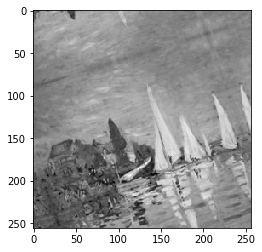

In [6]:
# Loading and reshaping the image we want to augment.

#img_path = fnames[0]
#img = image.load_img(img_path, target_size=(256,256,1))
x = Monet[0]
x = image.img_to_array(x)
x = x.reshape((1,) + x.shape)
print(x.shape)

# Generation
i=0
for batch in datagen.flow(x,batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='gray')
    i+=1
    if i%1==0:
        break

In [7]:
def build(data,factor,aug_number):
    # Number of monet pictures we want to augment. Ultimately, batch_monet = length_monet = 300
    batch_size=len(data)

    # Augmentation Number (aug_number) is the number of replications of every Monet picture we have
    data_augmented = np.zeros([batch_size,aug_number,256,256,1])

    for j in range(batch_size):
        img_path = fnames[j+factor]
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        
        # Generation
        for i in range(aug_number):
            gen = datagen.flow(x,batch_size = batch_size)
            for batch in gen:
                data_augmented[j,i,:,:,:] = batch[0]/255 
                i+=1
                if i % aug_number == 0:
                    break
    print("Done.")
    return(data_augmented.reshape(batch_size*aug_number,256,256))

In [40]:
aug_number = 16

train_monet_len = round(0.8*len(Monet))
test_monet_len = round(.15*len(Monet))
val_monet_len = len(Monet) - train_monet_len - test_monet_len

Monet_aug_train = build(Monet[0:train_monet_len],0,aug_number)
Monet_aug_test = build(Monet[train_monet_len:train_monet_len+test_monet_len],train_monet_len,aug_number)
Monet_aug_val = build(Monet[-val_monet_len:],train_monet_len+test_monet_len,aug_number)

Done.
Done.
Done.


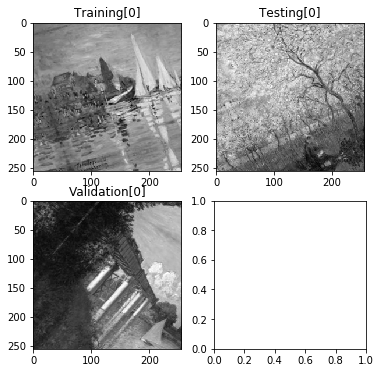

In [41]:
fig, axs = plt.subplots(2,2,figsize=(6,6))
axs[0, 0].imshow(Monet_aug_train[0,:,:],cmap='gray')
axs[0, 0].set_title("Training[0]")

axs[0, 1].imshow(Monet_aug_test[0,:,:],cmap='gray')
axs[0, 1].set_title("Testing[0]")

axs[1, 0].imshow(Monet_aug_val[0,:,:],cmap='gray')
axs[1, 0].set_title("Validation[0]")

plt.show()

In [118]:
# Splitting the pics into three sets, training, testing and validation

Pics_train = Photos[0:offset+Monet_aug_train.shape[0]]
Pics_test = Photos[offset+Monet_aug_train.shape[0]:offset+Monet_aug_train.shape[0]+Monet_aug_test.shape[0]]
Pics_val = Photos[offset+Monet_aug_train.shape[0]+Monet_aug_test.shape[0]:offset+Monet_aug_train.shape[0]+Monet_aug_test.shape[0]+Monet_aug_val.shape[0]]

In [119]:
training_dataset = np.zeros([len(Monet_aug_train)+len(Pics_train),256,256])
testing_dataset = np.zeros([2*len(Pics_test),256,256])

training_dataset[0:len(Monet_aug_train),:,:] = Monet_aug_train
training_dataset[len(Monet_aug_train):,:,:] = Pics_train

training_labels = np.zeros([len(Monet_aug_train)+len(Pics_train)])
training_labels[0:len(Monet_aug_train)] = np.ones([len(Monet_aug_train)])

In [120]:
testing_dataset[0:len(Pics_test),:,:] = Monet_aug_test
testing_dataset[len(Pics_test):,:,:] = Pics_test

testing_labels = np.zeros([len(Monet_aug_test)+len(Pics_test)])
testing_labels[0:len(Pics_test)] = np.ones([len(Pics_test)])

In [121]:
validation_dataset = np.zeros([2*len(Pics_val),256,256])
validation_dataset[0:len(Monet_aug_val),:,:] = Monet_aug_val
validation_dataset[len(Monet_aug_val):,:,:] = Pics_val

validation_labels = np.zeros([2*len(Pics_val)])
validation_labels[0:len(Pics_val)] = np.ones([len(Pics_val)])

In [122]:
def shuffle_data(data):
    list=[]
    for i in range(len(data)):
        list.append(data[i,:,:])
    
    random.Random(0).shuffle(list)
    data_shuffled = np.array(list)
    
    return(data_shuffled)

def shuffle_labels(labels):
    list = labels.tolist()
    random.Random(0).shuffle(list)
    shuffled_labels = np.array(list)
    return(shuffled_labels)

In [123]:
shuffled_training_labels = shuffle_labels(training_labels)
shuffled_testing_labels = shuffle_labels(testing_labels)

shuffled_training_data = shuffle_data(training_dataset)
shuffled_testing_data = shuffle_data(testing_dataset)

In [124]:
shuffled_training_data = shuffled_training_data.reshape(len(shuffled_training_data),256,256,1)
shuffled_testing_data = shuffled_testing_data.reshape(len(shuffled_testing_data),256,256,1)
validation_dataset = validation_dataset.reshape(len(validation_dataset),256,256,1)

In [125]:
print("Length of the training set :",len(shuffled_training_data))
print("")
print("Length of the testing set :",len(shuffled_testing_data))
print("")
print("Length of the validation set :",len(validation_dataset))

Length of the training set : 8680

Length of the testing set : 1440

Length of the validation set : 480


## ConvNet

In [ ]:
# Conv Neural Net

epochs_number = 6

model=models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu',input_shape=(256,256,1,)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

history = model.fit(shuffled_training_data,shuffled_training_labels,epochs=epochs_number,
                    batch_size=64,
                    validation_data=(shuffled_testing_data,shuffled_testing_labels))

In [ ]:
#history_dict.keys()

history_dict = history.history
loss_values= history_dict['loss']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_acc']
acc = history_dict['acc']
epochs = range(1, epochs_number+1)
plt.plot(epochs,loss_values, 'bo',color='red',label='Training Loss')
plt.plot(epochs,val_loss, 'b',color='purple',label='Validation Loss')
plt.title("Overfitting")
plt.legend()
plt.show()
plt.clf()
plt.plot(epochs,acc, 'bo',color='red',label='Training Accuracy')
plt.plot(epochs,val_acc, 'b',color='purple',label='Validation Accuracy')
plt.legend()
plt.show()

## Visualization

In [133]:
valshape = validation_dataset.reshape(len(validation_dataset),256,256)

def test_model():
    validation = model.evaluate(validation_dataset,validation_labels)
    print("")
    print("Accuracy of the model on the validation set :",round(100*validation[1],2),"%")
    print("")
    
    print('------------------------------------------------------------------------')
    print("")
    
    prediction = model.predict(validation_dataset)

    misstakes = 0
    miss_monet = 0
    miss_pics = 0
    for i in range(len(prediction)):
        if round(prediction[i][0]) != validation_labels[i]:
            misstakes+=1
            if validation_labels[i]==0:
                miss_pics+=1
            else:
                miss_monet+=1

    #print("Length of the validation set :",len(prediction))     
    print("Number of mistakes :",misstakes)
    #print("Number of mistakes on Monet-pictures :",miss_monet)
    #print("Number of mistakes on non-Monet pictures:",miss_pics)
    print("")
    print("Percentage of mistakes :",round(100*misstakes/len(prediction),2),"%")
    print("")
    print("Accuracy on Monet pictures",100-round(100*2*miss_monet/len(prediction),2),"%")
    print("")
    print("Accuracy on non-Monet pictures",100-round(100*2*miss_pics/len(prediction),2),"%")
    
    print("")
    print('------------------------------------------------------------------------')
    print("")
    
    fig, axs = plt.subplots(2,2,figsize=(8,8))
    axs[0, 0].imshow(valshape[49,:,:],cmap='gray')
    axs[0, 0].set_title(prediction[49])
    axs[0, 1].imshow(valshape[5,:,:],cmap='gray')
    axs[0, 1].set_title(prediction[5])
    axs[1, 0].imshow(valshape[91,:,:],cmap='gray')
    axs[1, 0].set_title(prediction[91])
    axs[1, 1].imshow(valshape[90,:,:],cmap='gray')
    axs[1, 1].set_title(prediction[90])
    plt.show()
    
    print("")
    print('------------------------------------------------------------------------')
    print("")
    
    print("A few examples of pictures the model couldn't predict :")
    print("")
    
    missed=[]
    r=0
    for i in range(len(prediction)):
        if round(prediction[i][0]) != validation_labels[i]:
            r+=1
            missed.append(i)
        if r > 3:
            break
            
    fig, axs = plt.subplots(2,2,figsize=(8,8))
    axs[0, 0].imshow(valshape[missed[0],:,:],cmap='gray')
    axs[0, 0].set_title(prediction[missed[0]])
    
    axs[0, 1].imshow(valshape[missed[1],:,:],cmap='gray')
    axs[0, 1].set_title(prediction[missed[1]])
    
    axs[1, 0].imshow(valshape[missed[2],:,:],cmap='gray')
    axs[1, 0].set_title(prediction[missed[2]])
    
    axs[1, 1].imshow(valshape[missed[3],:,:],cmap='gray')
    axs[1, 1].set_title(prediction[missed[3]])
    plt.show()
    
    return((100-round(100*2*miss_monet/len(prediction),2)),100-round(100*2*miss_pics/len(prediction),2))

480/480 [==============================] - 6s 13ms/step

Accuracy of the model on the validation set : 95.63 %

------------------------------------------------------------------------

Number of mistakes : 21

Percentage of mistakes : 4.38 %

Accuracy on Monet pictures 92.5 %

Accuracy on non-Monet pictures 98.75 %

------------------------------------------------------------------------



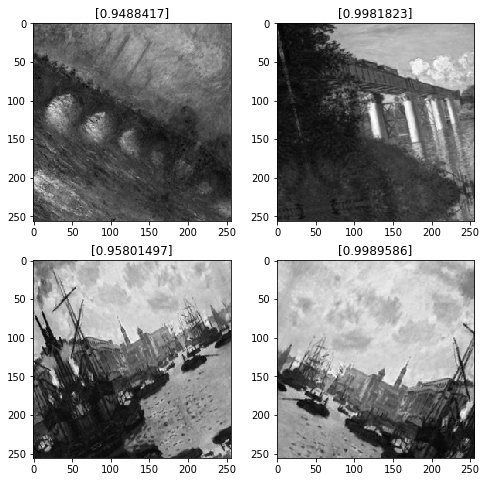


------------------------------------------------------------------------

A few examples of pictures the model couldn't predict :



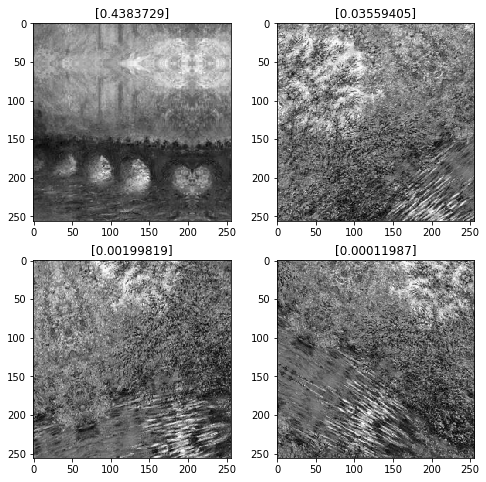

In [135]:
accuracy_result = test_model()

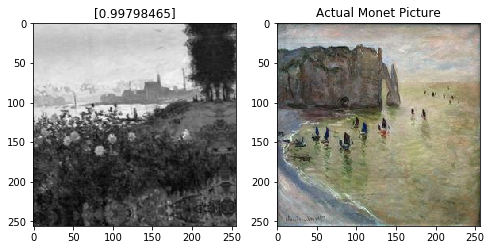

In [132]:
prediction = model.predict(validation_dataset)
aug_number=4
#index=round(0.85*len(Monet))-(35/4)
path_250 = fnames[250]
img250 = cv2.imread(path_250,cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(valshape[35,:,:],cmap='gray')
axs[0].set_title(prediction[35])
axs[1].imshow(img250,cmap='viridis')
axs[1].set_title('Actual Monet Picture')
plt.show()

In [142]:
print('\033[1m','The model is more accurate on Non-Monet pictures, which is not bad news, since we want to use this classifier to discriminate Non-Monet pictures accurately for the GAN application','\033[0m')

print("")
print("Accuracy on Monet pictures :",accuracy_result[0])
print("")
print("Accuracy on regular pictures :",accuracy_result[1])

 The model is more accurate on Non-Monet pictures, which is not bad news, since we want to use this classifier to discriminate Non-Monet pictures accurately for the GAN application 

Accuracy on Monet pictures : 92.5

Accuracy on regular pictures : 98.75


array([[1.]], dtype=float32)

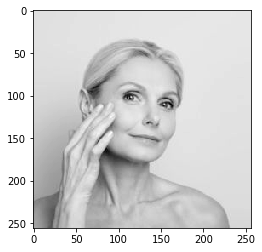

In [258]:
# Use a pre-trained network to avoid this kind of problem :

img = cv2.imread('/Users/Casey/Desktop/img1.jpg',cv2.IMREAD_GRAYSCALE) 
plt.imshow(img,cmap='gray')
img=img.reshape(1,256,256,1)
model.predict(img)